# Chromatin Loop Calling Benchmark

This notebook contains the code to reproduce Figure 2 and S4-S7.

Required data are:

1. Takei et al, 2021, Nature: 25 Kb dataset from two biological replicates

    data.json: takei_nature_2021, 25Kb, rep1 and rep2

    4DN data portal ID: 4DNFIHF3JCBY (rep1), 4DNFIQXONUUH (rep2)

2. Huang et al, 2021, Nature Genetics: 

    data.json: huang_ng_2021, between

    4DN data portal ID: 4DNFI2RCYFJU

3. ChIP-seq data of mouse embryonic stem cells

    data.json: chipseq_mesc

4. HiCExplorer and FitHiC2 loop calling results

    details described in the manuscript

    output stored in:

    - ../data/bonev_cell_2017/hicexplorer.bedgraph
    - ../data/bonev_cell_2017/output/merged.spline_pass1.res10000.significances.fdr.0.01.bedpe

5. ChIA-PET data of mouse embryonic stem cells

    data.json: chiapet_mesc

6. PLAC-seq loops from mESCs

    downloaded from MAPS paper (PMID: 30986246) data S1

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as ad

from utils.data import DataTree
from utils import out_dire
import arcfish as af

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
dtree = DataTree("../data")

In [4]:
loader = af.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, nm_ratio={"X": 1000, "Y": 1000, "Z": 1000})

## Reference loops from six different loop lists

In [5]:
from utils.utils import filter_loops
plac_ctcf_path = "../data/MAPS/mESC_CTCF_combine_MAPS_call.bedpe"
plac_ctcf = pd.read_csv(plac_ctcf_path, sep="\t")
# Keep cluster summits and singletons
plac_ctcf = plac_ctcf[(plac_ctcf.summit==1)|(plac_ctcf.type=="Singleton")]
plac_ctcf = filter_loops(plac_ctcf, loader)
plac_ctcf.shape

(158, 7)

In [6]:
plac_h3k4me3_path = "../data/MAPS/mESC_H3K4me3_combine_MAPS_call.bedpe"
plac_h3k4me3 = pd.read_csv(plac_h3k4me3_path, sep="\t")
# Keep cluster summits and singletons
plac_h3k4me3 = plac_h3k4me3[(plac_h3k4me3.summit==1)|(plac_h3k4me3.type=="Singleton")]
plac_h3k4me3 = filter_loops(plac_h3k4me3, loader)
plac_h3k4me3.shape

(238, 7)

In [10]:
ctcf_pet_path = dtree["chiapet_mesc", "CTCF", "129S1/SvImJ"]
ctcf_pet = pd.read_csv(ctcf_pet_path, sep="\t", header=None)
ctcf_pet.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "count"]
ctcf_pet = ctcf_pet[ctcf_pet["count"] > 5]
ctcf_pet = filter_loops(ctcf_pet, loader)
ctcf_pet.shape

(243, 7)

In [8]:
polr2a_pet_path = dtree["chiapet_mesc", "POLR2A", "129S1/SvImJ"]
polr2a_pet = pd.read_csv(polr2a_pet_path, sep="\t", header=None)
polr2a_pet.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "count"]
polr2a_pet = polr2a_pet[polr2a_pet["count"] > 5]
polr2a_pet = filter_loops(polr2a_pet, loader)
polr2a_pet.shape

(297, 7)

In [9]:
hicexpl_path = "../data/bonev_cell_2017/hicexplorer.bedgraph"
edf = pd.read_csv(hicexpl_path, sep="\t", header=None)
edf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "pval"]
edf["c1"] = "chr" + edf["c1"].astype(str)
edf["c2"] = "chr" + edf["c2"].astype(str)
edf = filter_loops(edf, loader)
edf.shape

(55, 7)

In [11]:
fithic2_path = "../data/bonev_cell_2017/output/" \
    + "merged.spline_pass1.res10000.significances.fdr.0.01.bedpe"
fdf = pd.read_csv(fithic2_path, sep="\t", header=None)
fdf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "CC", "pval", "fdr"]
fdf = filter_loops(fdf, loader)
fdf.shape

(213, 7)

In [12]:
loop_dfs = {
    "plac_ctcf": plac_ctcf, "plac_h3k4me3": plac_h3k4me3, "ctcf_pet": ctcf_pet, 
    "polr2a_pet": polr2a_pet, "hicexpl": edf, "fithic2": fdf
}
common_loops = af.tl.all_possible_pairs(loader)
for k, v in loop_dfs.items():
    common_loops[k] = af.tl.loop_overlap(common_loops, v, -1)["overlapped"]
common_loops["count"] = (common_loops.iloc[:,-6:]==3).sum(axis=1)
common_loops = common_loops[common_loops["count"] > 1]
common_loops.to_csv(os.path.join(out_dire, "common_loops.bedpe"), sep="\t", index=False)

In [13]:
len(common_loops)

154

## Simulation with various z-axis error

In [14]:
n = 800
err = {"X": 0, "Y": 0, "Z": 50}
np.random.seed(1)

adata = loader.create_adata("chr14")

sub_adata = ad.AnnData(
    obs=np.arange(n, dtype="int64"),
    var=adata.var,
    layers={c: adata[
        adata.obs.sample(n=n, replace=True).index
    ].layers["X"] for c in "XYZ"},
    uns=adata.uns
)
sub_adatan = sub_adata.copy()
for c in "XYZ":
    e = stats.norm.rvs(size=sub_adata.shape, scale=err[c])
    sub_adata.layers[c] -= np.nanmean(sub_adata.layers[c], axis=1)[:,None]
    sub_adata.layers[c] += e

In [15]:
loop = af.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=af.tl.TwoSampleT)
res1, res11 = loop.call_loops(sub_adata), loop.call_loops(sub_adatan)
loop = af.tl.LoopCaller(gap=50e3, ltclass=af.tl.AxisWiseF)
res2, res21 = loop.call_loops(sub_adata), loop.call_loops(sub_adatan)
mat1 = af.pp.median_pdist(sub_adata, False)
mat2 = af.pp.median_pdist(sub_adatan, False)
lim = (sub_adata.var.Chrom_Start.min(), sub_adata.var.Chrom_End.max())

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: Runtime

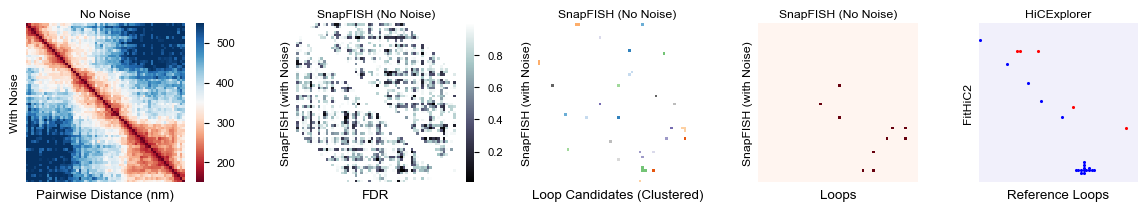

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
af.pl.pairwise_heatmap(mat1, mat2, x="No Noise", y="With Noise",
                       vmin=150, vmax=550, ax=axes[0])
axes[0].set_title("Pairwise Distance (nm)", y=-0.15)
af.pl.pairwise_heatmap(res1["fdr"], res11["fdr"], x="SnapFISH (No Noise)", 
                       y="SnapFISH (with Noise)", ax=axes[1], cmap="bone", 
                       cbar_kws={'ticks': np.linspace(0, 1, 6)})
axes[1].set_title("FDR", y=-0.15)
af.pl.pairwise_heatmap(res1["label"], res11["label"], x="SnapFISH (No Noise)", 
                       y="SnapFISH (with Noise)", ax=axes[2], cmap="tab20c", cbar=False)
axes[2].set_title("Loop Candidates (Clustered)", y=-0.15)
af.pl.pairwise_heatmap(res1["summit"], res11["summit"], x="SnapFISH (No Noise)", 
                       y="SnapFISH (with Noise)", ax=axes[3], cmap="Reds", cbar=False)
axes[3].set_title("Loops", y=-0.15)
axes[4].set(xlim=lim, ylim=lim)
af.pl.compare_loops(edf, fdf, sub_adata.uns["Chrom"], ax=axes[4])
axes[4].set_title("Reference Loops", y=-0.15)
axes[4].spines[["top", "bottom", "right", "left"]].set_visible(False)
axes[4].xaxis.set_label_coords(0.5, 1.085)
axes[4].set_xticks([])
axes[4].set(xlabel="HiCExplorer", ylabel="FitHiC2")
axes[4].set_facecolor("#f1f0fb")
fig.savefig(os.path.join(out_dire, "loop_calling_sf1.pdf"), bbox_inches="tight")

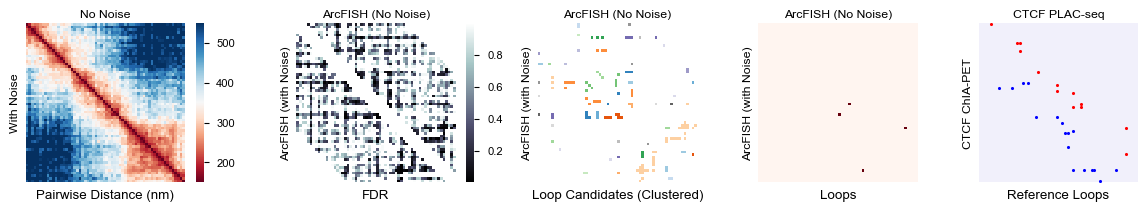

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
af.pl.pairwise_heatmap(mat1, mat2, x="No Noise", y="With Noise", 
                       vmin=150, vmax=550, ax=axes[0])
axes[0].set_title("Pairwise Distance (nm)", y=-0.15)
af.pl.pairwise_heatmap(res2["fdr"], res21["fdr"], x="ArcFISH (No Noise)", 
                       y="ArcFISH (with Noise)", ax=axes[1], cmap="bone", 
                       cbar_kws={'ticks': np.linspace(0, 1, 6)})
axes[1].set_title("FDR", y=-0.15)
af.pl.pairwise_heatmap(res2["label"], res21["label"], x="ArcFISH (No Noise)", 
                       y="ArcFISH (with Noise)", ax=axes[2], cmap="tab20c", cbar=False)
axes[2].set_title("Loop Candidates (Clustered)", y=-0.15)
loops1 = np.where(res2["pval"] < 1e-5, res2["summit"], 0)
loops2 = np.where(res21["pval"] < 1e-5, res21["summit"], 0)
af.pl.pairwise_heatmap(loops1, loops2, x="ArcFISH (No Noise)", 
                       y="ArcFISH (with Noise)", ax=axes[3], cmap="Reds", cbar=False)
axes[3].set_title("Loops", y=-0.15)
axes[4].set(xlim=lim, ylim=lim)
af.pl.compare_loops(plac_ctcf, ctcf_pet, sub_adata.uns["Chrom"], ax=axes[4])
axes[4].set_title("Reference Loops", y=-0.15)
axes[4].spines[["top", "bottom", "right", "left"]].set_visible(False)
axes[4].xaxis.set_label_coords(0.5, 1.085)
axes[4].set_xticks([])
axes[4].set(xlabel="CTCF PLAC-seq", ylabel="CTCF ChIA-PET")
axes[4].set_facecolor("#f1f0fb")
fig.savefig(os.path.join(out_dire, "loop_calling_sf2.pdf"), bbox_inches="tight")

Run `figures/scripts/11_err_rep.py` as described in the file. 

This creates two tsv files:

- loop_err_rep_all.tsv
- domain_err_rep_all.tsv

In [18]:
rep_call_all = pd.read_csv(os.path.join(out_dire, "loop_err_rep_all.tsv"), sep="\t")
rep_call_all = rep_call_all[rep_call_all.final]
grp_obj = rep_call_all.groupby(["method", "err", "rep"], sort=False)
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]

rows = []
for (m, e, r), df in grp_obj:
    tp = af.tl.loop_overlap(df, common_loops)
    tp = tp[tp["overlapped"]==3]
    pr = len(tp)/len(df)
    rc = len(tp)/len(common_loops)
    rows.append([m, e, r, len(df), len(tp), pr, rc])
rows = pd.DataFrame(rows, columns=["method", "err", "rep", "total", "tp", "precision", "recall"])

In [19]:
c1, c2 = sns.palettes.color_palette("dark")[:2]

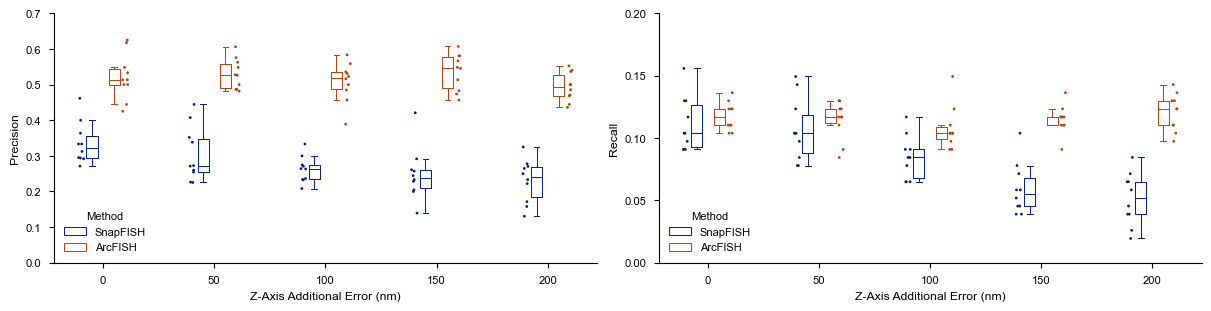

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
palette = {"SnapFISH": c1, "ArcFISH": c2}
for ax, y in zip(axes, ["precision", "recall"]):
    sns.boxplot(rows, x="err", y=y, hue="method", native_scale=True, linewidth=.7, 
                fliersize=0, fill=False, gap=1.5, width=.4, palette=palette, ax=ax)
    sns.stripplot(rows, x="err", y=y, hue="method", native_scale=True, s=2, 
                dodge=True, linewidth=0, jitter=.05, palette=palette, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Method", loc="lower left")
    ax.set(xlabel="Z-Axis Additional Error (nm)")
    ax.grid(False)
axes[0].set(ylabel="Precision", ylim=(0, 0.7))
axes[1].set(ylabel="Recall", ylim=(0, 0.2), yticks=[0, .05, 0.1, 0.15, 0.2])
fig.savefig(os.path.join(out_dire, "loop_calling_err.pdf"), bbox_inches="tight")

In [22]:
rows.groupby(["method", "err"]).mean()

rep  total    tp  precision    recall
method   err                                       
ArcFISH  0    4.5   34.9  18.1   0.522084  0.117532
         50   4.5   33.2  17.6   0.530125  0.114286
         100  4.5   32.9  16.6   0.507886  0.107792
         150  4.5   33.4  17.7   0.535542  0.114935
         200  4.5   37.7  18.6   0.493515  0.120779
SnapFISH 0    4.5   51.3  17.1   0.335639  0.111039
         50   4.5   54.8  16.4   0.305186  0.106494
         100  4.5   50.1  13.0   0.261701  0.084416
         150  4.5   37.0   9.1   0.248116  0.059091
         200  4.5   33.5   7.9   0.230307  0.051299

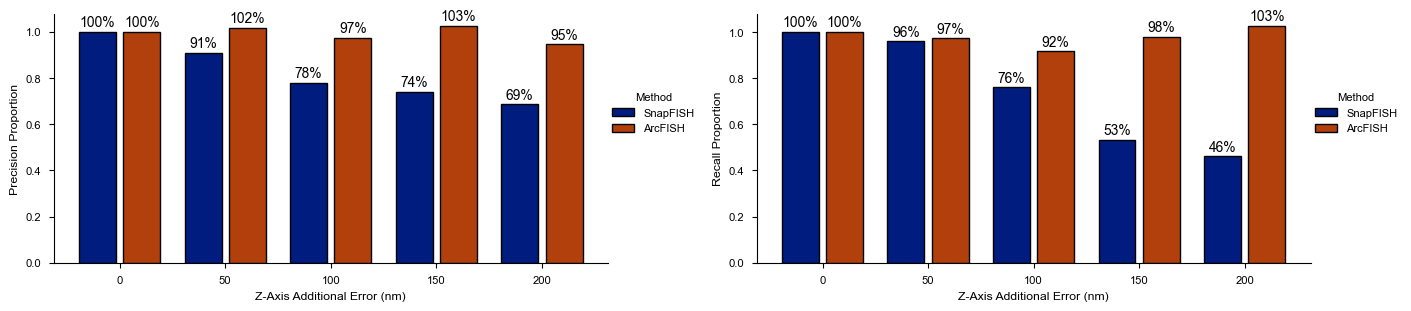

In [24]:
from utils.lines import prc_proportion
fig, axes = plt.subplots(1, 2, figsize=(14, 3))
prc_proportion(axes[0], rows, "precision", palette)
prc_proportion(axes[1], rows, "recall", palette)
fig.savefig(os.path.join(out_dire, "loop_calling_prc.pdf"), bbox_inches="tight")

## Loop calling on original data

In [25]:
res_sf1_path = os.path.join(out_dire, "loop_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    loop = af.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=af.tl.TwoSampleT)
    af.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "loop_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    loop = af.tl.LoopCaller(pval_cutoff=1e-5, gap=50e3, ltclass=af.tl.AxisWiseF)
    af.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

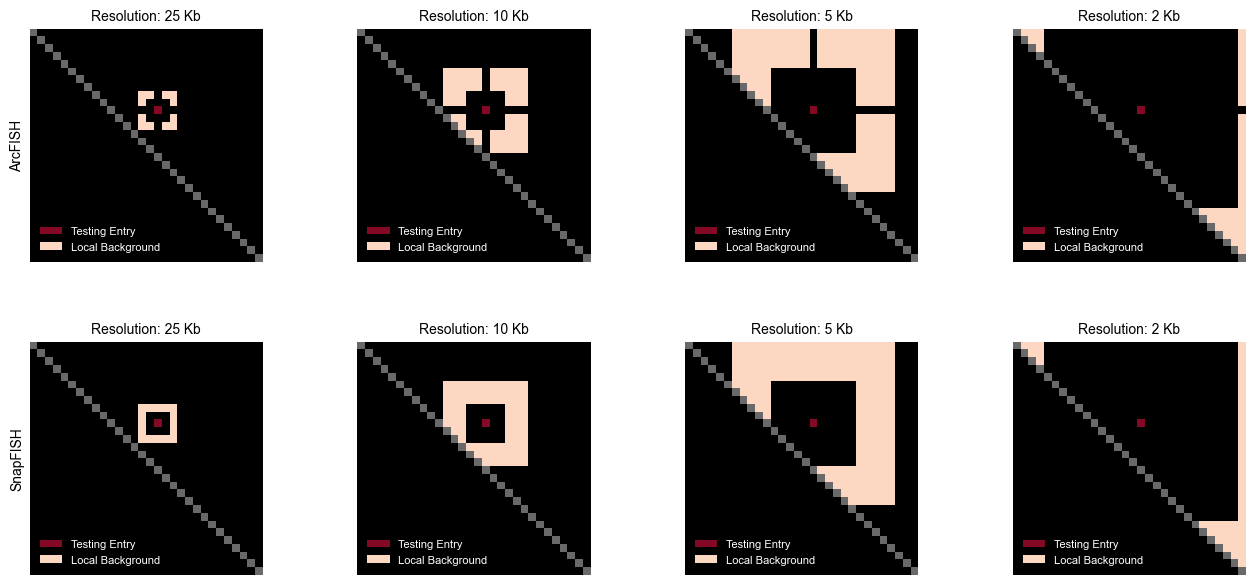

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7), constrained_layout=False)
for i, resol in enumerate([25e3, 10e3, 5e3, 2e3]):
    af.pl.background_model(10, 16, 50e3, af.tl.AxisWiseF, resol, 30, ax=axes[0,i])
    axes[0,i].set_title(f"Resolution: {int(resol/1e3)} Kb", fontsize=10)
    af.pl.background_model(10, 16, 50e3, af.tl.TwoSampleT, resol, 30, ax=axes[1,i])
    axes[1,i].set_title(f"Resolution: {int(resol/1e3)} Kb", fontsize=10)
    if i == 0:
        axes[0,i].set_ylabel("ArcFISH", fontsize=10)
        axes[1,i].set_ylabel("SnapFISH", fontsize=10)
fig.tight_layout(pad=5)
fig.savefig(os.path.join(out_dire, "background_model.pdf"))

In [28]:
loop_dfs = {
    "plac_ctcf": plac_ctcf, "plac_h3k4me3": plac_h3k4me3, "ctcf_pet": ctcf_pet, 
    "polr2a_pet": polr2a_pet, "hicexpl": edf, "fithic2": fdf
}
test_dfs0, test_dfs1 = [], []
for df in [res_sf1, res_sf2]:
    test_df0 = df[(df.final)&(df["c1"]!="chrX")].copy()
    test_df1 = df[(df.final)&(df["c1"]!="chrX")].copy()
    print(len(test_df0), end="\t")
    for k, v in loop_dfs.items():
        test_df0[k] = af.tl.loop_overlap(test_df0, v, 0)["overlapped"]
        test_df1[k] = af.tl.loop_overlap(test_df0, v, -1)["overlapped"]
    test_df0["count"] = (test_df0.iloc[:, -6:] == 3).sum(axis=1)
    test_df1["count"] = (test_df1.iloc[:, -6:] == 3).sum(axis=1)
    test_dfs0.append(test_df0)
    test_dfs1.append(test_df1)

41	25	

In [29]:
overlap_sf1 = af.tl.loop_overlap(
    res_sf1[(res_sf1.final)&(res_sf1["c1"]!="chrX")], common_loops, 0
)
o = overlap_sf1["overlapped"]==3
print(f"precision: {np.mean(o):.3f}, {np.sum(o)}")
overlap_sf2 = af.tl.loop_overlap(
    res_sf2[(res_sf2.final)&(res_sf2["c1"]!="chrX")], common_loops, 0
)
o = overlap_sf2["overlapped"]==3
print(f"precision: {np.mean(o):.3f}, {np.sum(o)}")

precision: 0.561, 23
precision: 0.680, 17


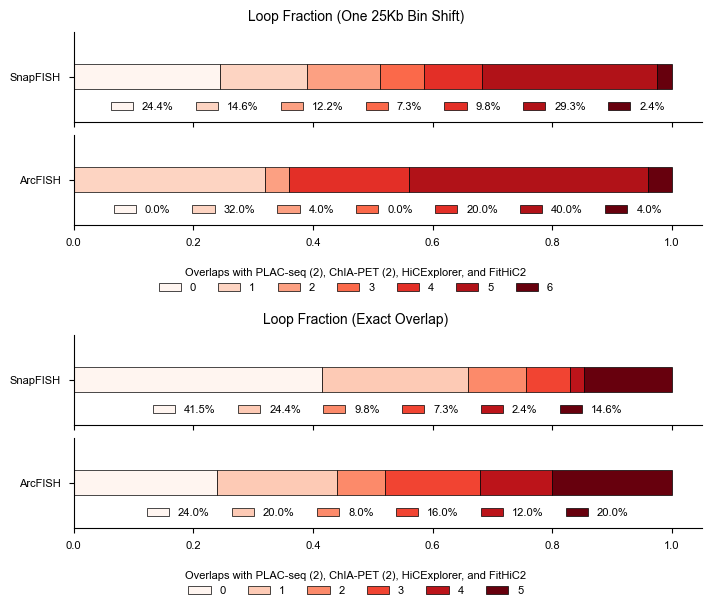

In [31]:
from utils.lines import loop_stack_bar
fig = plt.figure(figsize=(7, 6))
figs = fig.subfigures(2, 1)
loop_stack_bar(figs[0], test_dfs0)
figs[0].suptitle("Loop Fraction (One 25Kb Bin Shift)", fontsize=10)
loop_stack_bar(figs[1], test_dfs1)
figs[1].suptitle("Loop Fraction (Exact Overlap)", fontsize=10)
fig.savefig(os.path.join(out_dire, "loop_frac_stacked_bar.pdf"), bbox_inches="tight")

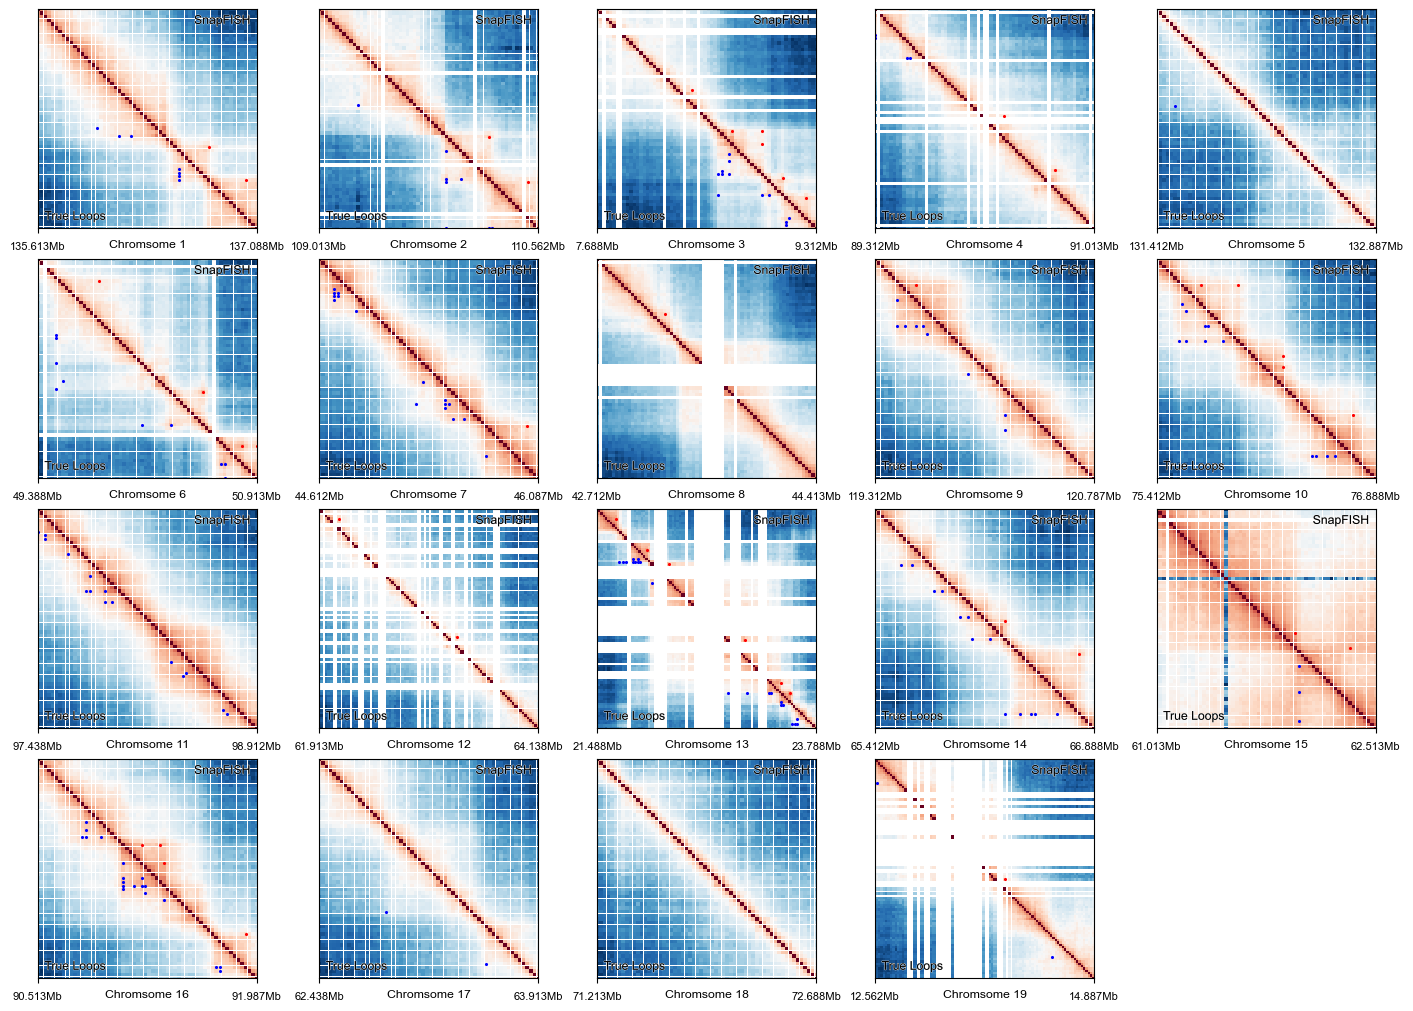

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i == 19:
        ax.axis("off")
        continue
    adata = loader.create_adata(f"chr{i+1}")
    med_dist = af.pp.median_pdist(adata, inplace=False)
    d1d = adata.var.mean(axis=1).values
    x, y = list(map(lambda x: x.flatten(), np.meshgrid(d1d, d1d)))
    hm_df = pd.DataFrame({"x": x, "y": y, "dist": med_dist.flatten()})
    sns.scatterplot(hm_df, x="x", y="y", hue="dist", ax=ax,
                    palette="RdBu", s=6, marker="s", linewidth=0)
    ax.set(xlim=(d1d.min(), d1d.max()), ylim=(d1d.min(), d1d.max()))
    af.pl.compare_loops(res_sf1[res_sf1.final], common_loops, chr_id=f"chr{i+1}", 
                        map1="SnapFISH", map2="True Loops", ax=ax)
    ax.get_legend().remove()
    ax.set(xlabel=f"Chromsome {i+1}")
fig.savefig(os.path.join(out_dire, "loop_sf1_all.pdf"), bbox_inches="tight")

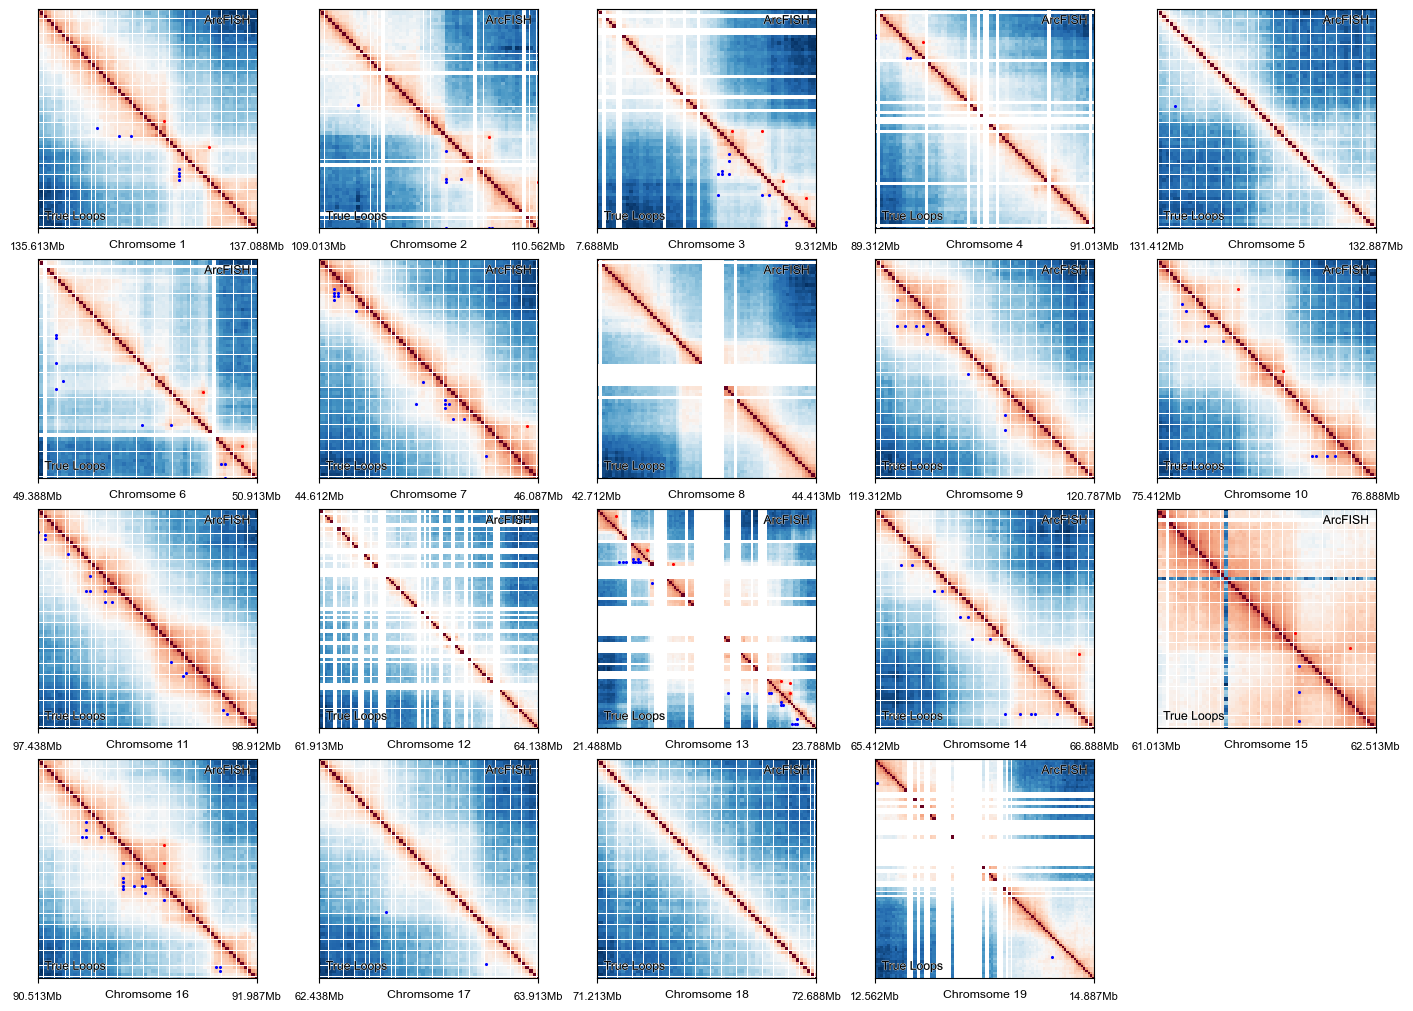

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [32]:
fig, axes = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i == 19:
        ax.axis("off")
        continue
    adata = loader.create_adata(f"chr{i+1}")
    med_dist = af.pp.median_pdist(adata, inplace=False)
    d1d = adata.var.mean(axis=1).values
    x, y = list(map(lambda x: x.flatten(), np.meshgrid(d1d, d1d)))
    hm_df = pd.DataFrame({"x": x, "y": y, "dist": med_dist.flatten()})
    sns.scatterplot(hm_df, x="x", y="y", hue="dist", ax=ax,
                    palette="RdBu", s=6, marker="s", linewidth=0)
    ax.set(xlim=(d1d.min(), d1d.max()), ylim=(d1d.min(), d1d.max()))
    af.pl.compare_loops(res_sf2[res_sf2.final], common_loops, chr_id=f"chr{i+1}", 
                        map1="ArcFISH", map2="True Loops", ax=ax)
    ax.get_legend().remove()
    ax.set(xlabel=f"Chromsome {i+1}")
fig.savefig(os.path.join(out_dire, "loop_sf2_all.pdf"), bbox_inches="tight")

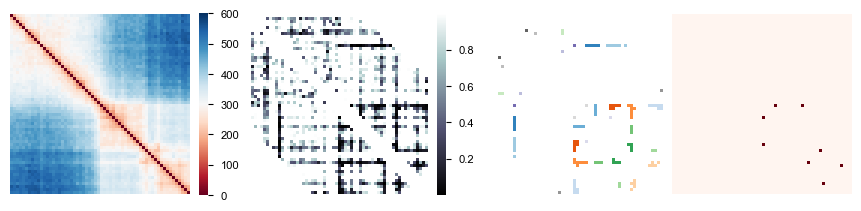

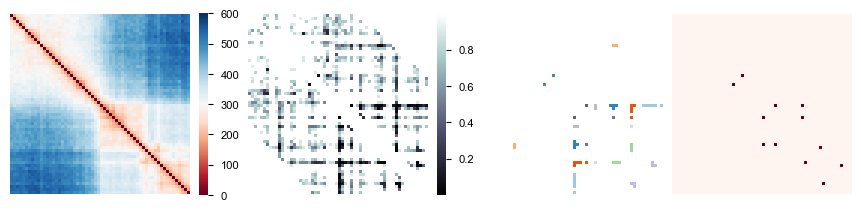

In [33]:
adata = loader.create_adata("chr3")
res = af.tl.LoopCaller().call_loops(adata)
fig, axes = plt.subplots(1, 4, figsize=(8.5, 2))
af.pl.pairwise_heatmap(af.pp.median_pdist(adata, False), ax=axes[0], vmax=600)
af.pl.pairwise_heatmap(res["fdr"], ax=axes[1], cmap="bone")
af.pl.pairwise_heatmap(res["label"], ax=axes[2], cmap="tab20c", cbar=False)
loops = np.where(res["pval"] < 1e-5, res["summit"], 0)
af.pl.pairwise_heatmap(loops, ax=axes[3], cmap="Reds", cbar=False)

res = af.tl.LoopCaller(pval_cutoff=1, ltclass=af.tl.TwoSampleT).call_loops(adata)
fig, axes = plt.subplots(1, 4, figsize=(8.5, 2))
af.pl.pairwise_heatmap(af.pp.median_pdist(adata, False), ax=axes[0], vmax=600)
af.pl.pairwise_heatmap(res["fdr"], ax=axes[1], cmap="bone")
af.pl.pairwise_heatmap(res["label"], ax=axes[2], cmap="tab20c", cbar=False)
af.pl.pairwise_heatmap(res["final"], ax=axes[3], cmap="Reds", cbar=False)

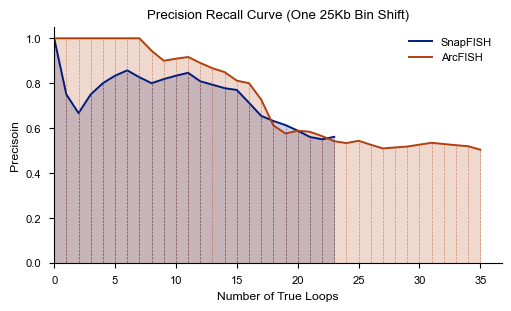

In [34]:
from utils.utils import precision_recall_res
fig, ax = plt.subplots(figsize=(5, 3))
df1 = precision_recall_res(res_sf1[res_sf1["c1"]!="chrX"], common_loops, 0)
df1["Method"] = "SnapFISH"
df2 = precision_recall_res(res_sf2[res_sf2["c1"]!="chrX"], common_loops, 0)
df2["Method"] = "ArcFISH"
sns.lineplot(pd.concat([df1, df2]), x="# True Loops", y="Precisoin", hue="Method", 
             palette={"SnapFISH": c1, "ArcFISH": c2}, errorbar=None, ax=ax)

x, y = ax.lines[0].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c1, alpha=0.2)
ax.vlines(x, 0, y, color=c1, alpha=0.5, linewidth=0.5, linestyle="--")

x, y = ax.lines[1].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c2, alpha=0.2)
ax.vlines(x, 0, y, color=c2, alpha=0.5, linewidth=0.5, linestyle="--")

ax.set(xlim=(-.03, ax.get_xlim()[1]), ylim=(0, 1.05))
ax.set(xlabel="Number of True Loops", 
       title="Precision Recall Curve (One 25Kb Bin Shift)")
ax.legend(loc="upper right")
ax.grid(False)
fig.savefig(os.path.join(out_dire, "loop_prc_onebin.pdf"), bbox_inches="tight")

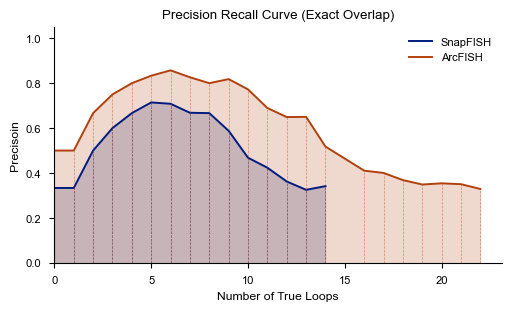

In [35]:
fig, ax = plt.subplots(figsize=(5, 3))
df1 = precision_recall_res(res_sf1[res_sf1["c1"]!="chrX"], common_loops, -1)
df1["Method"] = "SnapFISH"
df2 = precision_recall_res(res_sf2[res_sf2["c1"]!="chrX"], common_loops, -1)
df2["Method"] = "ArcFISH"
sns.lineplot(pd.concat([df1, df2]), x="# True Loops", y="Precisoin", hue="Method", 
             palette={"SnapFISH": c1, "ArcFISH": c2}, errorbar=None, ax=ax)

x, y = ax.lines[0].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c1, alpha=0.2)
ax.vlines(x, 0, y, color=c1, alpha=0.5, linewidth=0.5, linestyle="--")

x, y = ax.lines[1].get_xydata().T
xnew = np.linspace(x.min(), x.max(), 1000)
ax.fill_between(xnew, np.interp(xnew, x, y), color=c2, alpha=0.2)
ax.vlines(x, 0, y, color=c2, alpha=0.5, linewidth=0.5, linestyle="--")

ax.set(xlim=(-.03, ax.get_xlim()[1]), ylim=(0, 1.05))
ax.set(xticks=np.arange(0, 21, 5))
ax.set(xlabel="Number of True Loops", 
       title="Precision Recall Curve (Exact Overlap)")
ax.legend(loc="upper right")
ax.grid(False)
fig.savefig(os.path.join(out_dire, "loop_prc_exact.pdf"), bbox_inches="tight")

In [36]:
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
res_sf1_final, res_sf2_final = res_sf1[res_sf1.final], res_sf2[res_sf2.final]
shared = pd.merge(res_sf2_final, res_sf1_final[cols], how="inner", on=cols)
res_sf2_specific = pd.concat([res_sf2_final, shared]).drop_duplicates(cols, keep=False)

overlapped = af.tl.loop_overlap(res_sf2_final, common_loops, -1)
overlapped = overlapped[overlapped["overlapped"]==3]
len(overlapped)/len(res_sf2_final)

0.56

In [37]:
loop_pval1 = pd.merge(common_loops, res_sf1, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval1["type"] = "SnapFISH Loop"
null_pval1 = res_sf1.drop(loop_pval1.index)
null_pval1 = null_pval1[null_pval1.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval1["type"] = "SnapFISH Null"
loop_pval2 = pd.merge(common_loops, res_sf2, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval2["type"] = "ArcFISH Loop"
null_pval2 = res_sf2.drop(loop_pval2.index)
null_pval2 = null_pval2[null_pval2.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval2["type"] = "ArcFISH Null"

In [38]:
pvals = np.vstack([null_pval1.pval.values, null_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="less")

WilcoxonResult(statistic=129996298.0, pvalue=5.620811240800894e-29)

In [39]:
pvals = np.vstack([loop_pval1.pval.values, loop_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="greater")

WilcoxonResult(statistic=8515.0, pvalue=8.741258973963363e-07)

In [40]:
plt_df = pd.concat([loop_pval1, null_pval1, loop_pval2, null_pval2])
# +1e-20 to avoid log10(0)
plt_df["log10pval"] = -np.log10(plt_df["pval"]-1e-20)
plt_df = plt_df[["log10pval", "type"]].dropna()

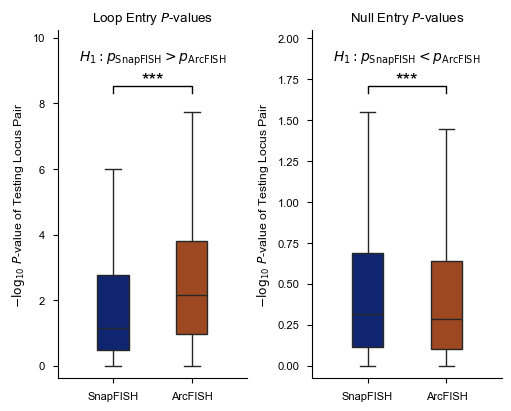

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(5, 4))
plt_df["side"] = plt_df["type"].str.replace("^.*\\s", "", regex=True)
plt_df["test"] = plt_df["type"].str.replace("\\s.*$", "", regex=True)
palette = {"SnapFISH": c1, "ArcFISH": c2}

for ax, side in zip(axes, ["Loop", "Null"]):
    df = plt_df[plt_df["side"] == side]
    sns.boxplot(df, y="log10pval", x="test", hue="test", palette=palette,
                showfliers=False, width=.4, legend=False, ax=ax)
    ax.grid(False)
    ax.set(xlabel=None, ylabel=r"$-\log_{10}\,P$-value of Testing Locus Pair")
    ax.set_title(rf"{side} Entry $P$-values")
    yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax.set(ylim=(ax.get_ylim()[0], ax.get_ylim()[1] + yrange * .25), xlim=(-.7, 1.7))
    
    yrange /= 1.05
    h = (ax.get_ylim()[1] - ax.get_ylim()[0])*.02
    ax.plot([0, 0, 1, 1], np.array([h, 2*h, 2*h, h]) + yrange, color="k", lw=1)
    ax.text(.5, 2*h + yrange, "***", ha="center", fontsize=14)
    ax.text(.5, 6*h + yrange, 
            fr"$H_1: p_{{\text{{SnapFISH}}}} {{{'>' if side == 'Loop' else '<'}}} p_{{\text{{ArcFISH}}}}$", 
            va="center", ha="center")
fig.savefig(os.path.join(out_dire, "loop_pval.pdf"), bbox_inches="tight")

## Sox2 Chromatin Tracing

In [42]:
adatas_5kb = {}
for key in ["between", "downstream", "between_mutant"]:
    adatas_5kb[key] = af.pp.FOF_CT_Loader(dtree["huang_ng_2021", key]).create_adata("chr3")
    allele = adatas_5kb[key].obs.index.str.replace(r"^.*_", "", regex=True)
    adatas_5kb[key].obs["allele"] = allele

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


In [43]:
from itertools import product
res = []
for key, allele in product(adatas_5kb, ["129", "CAST"]):
    a = adatas_5kb[key]
    m = np.mean(np.isnan(a[a.obs["allele"]==allele].layers["X"]), axis=0)
    df = pd.Series(m).to_frame("frac")
    df["key"] = key
    df["allele"] = allele
    df["var"] = a.var.index
    res.append(df)
res = pd.concat(res, ignore_index=True)

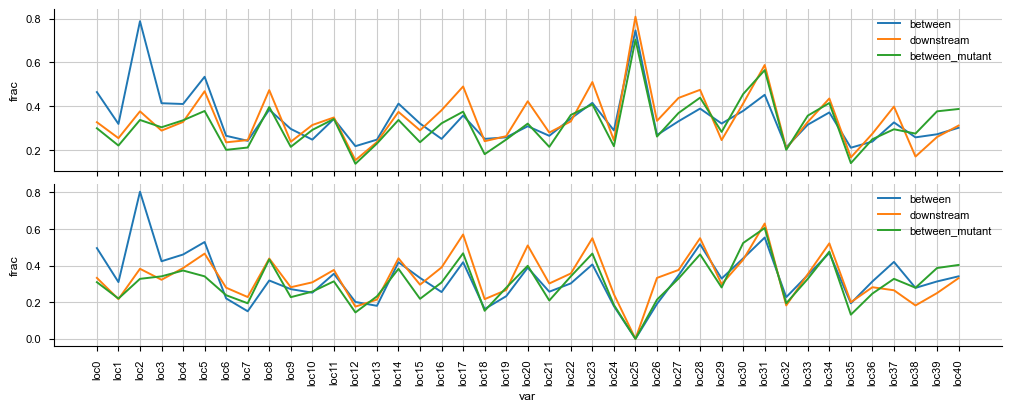

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
sns.lineplot(res[res["allele"]=="129"], x="var", y="frac", hue="key", ax=axes[0])
axes[0].legend(loc="upper right")
sns.lineplot(res[res["allele"]=="CAST"], x="var", y="frac", hue="key", ax=axes[1])
axes[1].legend(loc="upper right")
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
plt.show()

In [45]:
for k, v in adatas_5kb.items():
    for c in "XYZ":
        v.layers[c][:,25] = np.nan

In [46]:
from itertools import product
res = []
for key, allele in product(adatas_5kb, ["129", "CAST"]):
    a = adatas_5kb[key]
    m = np.mean(np.isnan(a[a.obs["allele"]==allele].layers["X"]), axis=0)
    df = pd.Series(m).to_frame("frac")
    df["key"] = key
    df["allele"] = allele
    df["var"] = a.var.index
    res.append(df)
res = pd.concat(res, ignore_index=True)

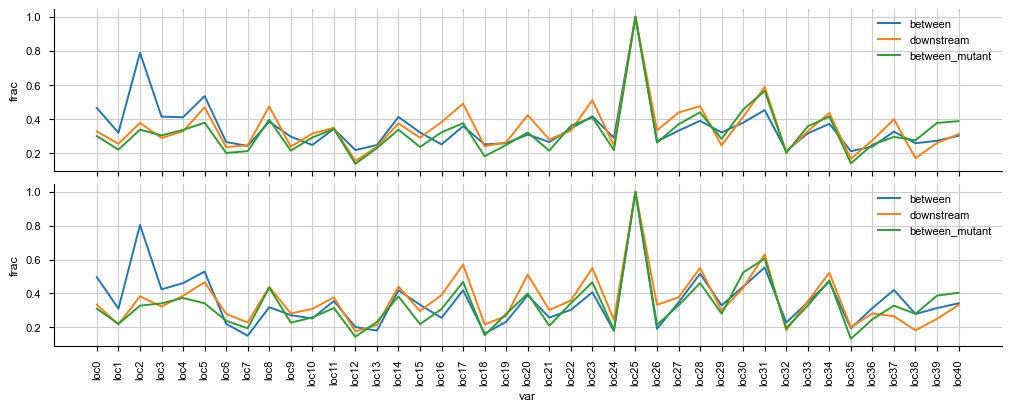

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
sns.lineplot(res[res["allele"]=="129"], x="var", y="frac", hue="key", ax=axes[0])
axes[0].legend(loc="upper right")
sns.lineplot(res[res["allele"]=="CAST"], x="var", y="frac", hue="key", ax=axes[1])
axes[1].legend(loc="upper right")
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
plt.show()

In [48]:
cast = adatas_5kb["between"][adatas_5kb["between"].obs["allele"]=="CAST"].copy()
c129 = adatas_5kb["between"][adatas_5kb["between"].obs["allele"]=="129"].copy()

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_80955/3344286185.py:4: RuntimeWarning: All-NaN slice encountered
  for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):


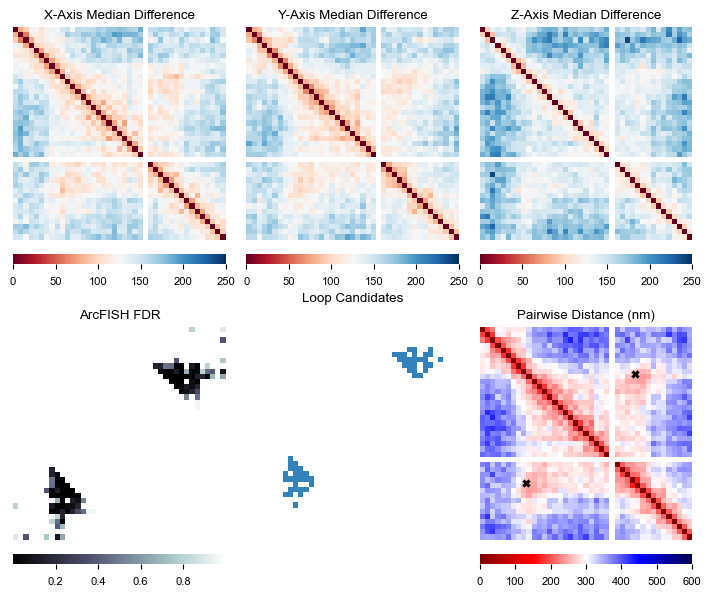

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(7, 6))
X = np.stack([c129.layers[c] for c in "XYZ"])
arr = X[:,:,None,:] - X[:,:,:,None]
for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):
    af.pl.pairwise_heatmap(mat, ax=axes.flat[i], vmax=250, 
                           title=f"{'XYZ'[i]}-Axis Median Difference", 
                           cbar_kws={"orientation": "horizontal"})
res = af.tl.LoopCaller().call_loops(c129)
af.pl.pairwise_heatmap(res["fdr"], title="ArcFISH FDR", ax=axes[1,0], cmap="bone", 
                       cbar_kws={"ticks": np.linspace(0, 1, 6), "orientation": "horizontal"})
af.pl.pairwise_heatmap(res["label"], title="Loop Candidates", 
                       ax=axes[1,1], cmap="tab20c", cbar=False)
med_dist = af.pp.median_pdist(c129, False)
af.pl.pairwise_heatmap(med_dist, title="Pairwise Distance (nm)", ax=axes[1,2], 
                       vmax=600, cmap="seismic_r", cbar_kws={"orientation": "horizontal"})
axes[1,2].scatter(*np.where(res["summit"]), color="k", marker="X")
fig.savefig(os.path.join(out_dire, "loop_calling_129.pdf"), bbox_inches="tight")

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_80955/263110440.py:4: RuntimeWarning: All-NaN slice encountered
  for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:187: RuntimeWarning: Mean of empty slice
  xvars = np.nanmean(np.square(x0), axis=0)


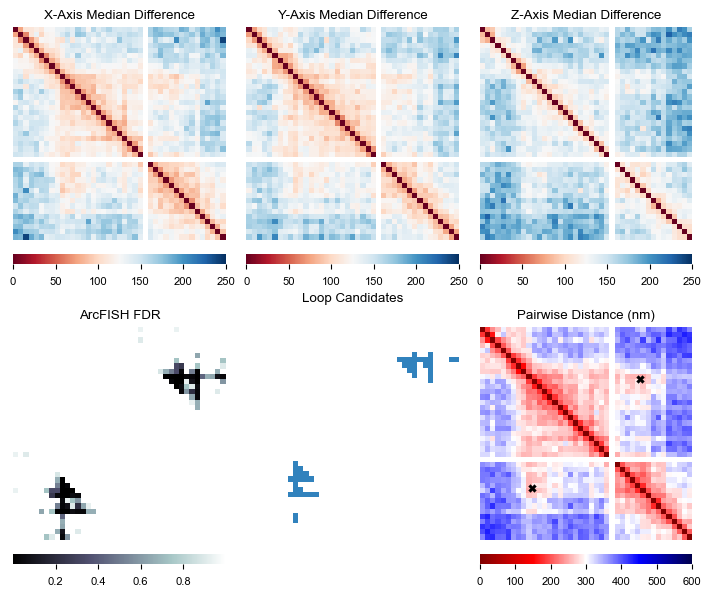

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(7, 6))
X = np.stack([cast.layers[c] for c in "XYZ"])
arr = X[:,:,None,:] - X[:,:,:,None]
for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=1)):
    af.pl.pairwise_heatmap(mat, ax=axes.flat[i], vmax=250, 
                           title=f"{'XYZ'[i]}-Axis Median Difference", 
                           cbar_kws={"orientation": "horizontal"})
res = af.tl.LoopCaller().call_loops(cast)
af.pl.pairwise_heatmap(res["fdr"], title="ArcFISH FDR", ax=axes[1,0], cmap="bone", 
                       cbar_kws={"ticks": np.linspace(0, 1, 6), "orientation": "horizontal"})
af.pl.pairwise_heatmap(res["label"], title="Loop Candidates", 
                       ax=axes[1,1], cmap="tab20c", cbar=False)
med_dist = af.pp.median_pdist(cast, False)
af.pl.pairwise_heatmap(med_dist, title="Pairwise Distance (nm)", ax=axes[1,2], 
                       vmax=600, cmap="seismic_r", cbar_kws={"orientation": "horizontal"})
axes[1,2].scatter(*np.where(res["summit"]), color="k", marker="X")
fig.savefig(os.path.join(out_dire, "loop_calling_cast.pdf"), bbox_inches="tight")

In [52]:
igv_tracks = [{"name": "HiCExplorer", "url": hicexpl_path, 
               "format": "bedpe", "height": 50, "color": "red"}]
k = "between"
adata = adatas_5kb[k]
for allele in ["129", "CAST"]:
    caller2 = af.tl.LoopCaller()
    a = adata[adata.obs["allele"]==allele].copy()
    res2 = caller2.to_bedpe(caller2.call_loops(a), a)
    f = os.path.join(out_dire, f"loop_result_{k}_{allele}.bedpe")
    res2[res2.final].iloc[:,:6].to_csv(f, sep="\t", index=False, header=False)
    print(k, allele, res2[res2.final]["pval"])
    igv_tracks.append({
        "name": f"{k} {allele}", "url": f, 
        "format": "bedpe", "height": 50
    })

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:187: RuntimeWarning: Mean of empty slice
  xvars = np.nanmean(np.square(x0), axis=0)


between 129 344    4.132175e-09
Name: pval, dtype: float64
between CAST 375    3.258084e-08
Name: pval, dtype: float64


/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:187: RuntimeWarning: Mean of empty slice
  xvars = np.nanmean(np.square(x0), axis=0)
